### based on
- http://localhost:8187/notebooks/tsainbur/Projects/github_repos/cdcp_chronic/notebooks/neural-analysis/spiketrain_analyses/analyses/1.0-determine-categorical-units.ipynb
- http://localhost:8187/notebooks/tsainbur/Projects/github_repos/cdcp_chronic/notebooks/neural-analysis/spiketrain_analyses/analyses/analyze-spike-shape.ipynb

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
# set to be lower priority
#os.nice(1)

In [3]:
import pandas  as pd
from cdcp.paths import DATA_DIR, ensure_dir
import numpy as np
import matplotlib.pyplot as plt
import datetime
from pathlib2 import Path
from tqdm.autonotebook import tqdm
pd.set_option('display.max_columns', 500)
from joblib import Parallel, delayed
from datetime import datetime
from joblib import Parallel, delayed
from functools import reduce
from sklearn.decomposition import PCA
from functools import reduce


/home/AD/tsainbur/anaconda3/envs/cdcp_paper/lib/python3.7/site-packages/ipykernel_launcher.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  import sys


In [4]:
from cdcp.paths import DATA_PATH_MAGPI, FIGURE_DIR, ensure_dir
from cdcp.general import save_fig

In [5]:
import seaborn as sns
from cdcp.behavior.psychometric import FourParameterLogistic, fit_FourParameterLogistic
import scipy.stats
from cdcp.spiketrain_analysis.neurometric import (
    get_interp_points_dists_from_similarity_matrix,
)

In [6]:
from cdcp.visualization.colors import nuclei_dict
from scipy import interpolate

In [7]:
%matplotlib inline

In [8]:
# "2021-10-07_16-05-58_796914" '2021-10-06_13-30-08_899062' '2021-10-01_17-02-56_744915' 
statistics_timestamp = '2021-10-23_23-02-31_846685'# datetime.now().strftime("%Y-%m-%d_%H-%M-%S_%f")#
statistics_timestamp

'2021-10-23_23-02-31_846685'

In [9]:
unit_statistics_df = pd.read_pickle(DATA_DIR / 'categorical_unit_01_23_22.pickle')

In [10]:
len(unit_statistics_df)

13854

In [11]:
unit_statistics_df = unit_statistics_df[unit_statistics_df.categorical_unit == True]

In [12]:
len(unit_statistics_df)

7994

In [22]:
birds = [
    ('B1597', '2021-05-14_12-40-20_423998', 'kilosort2_5'),
    ('B1188', '2021-05-31_18-52-29_558216', 'kilosort2_5'),
    ('B1595', '2021-07-10_16-42-47_090257', 'kilosort2'),
    ('B1276', '2021-07-14_11-14-02_257025', 'kilosort2'),
    ('B1426', '2021-07-14_11-29-39_657273', 'kilosort2'),
    ('B1432', '2021-06-01_15-14-38_561892', 'kilosort2_5'),
    ('B1170', '2021-06-01_21-01-26_519005', 'kilosort2_5'),
    ('B1244', '2021-07-14_12-57-45_546674', 'kilosort2'),
    ('B1593', '2021-06-28_18-13-24_826008', 'kilosort2_5'),
    ('B1248', '2021-07-03_18-08-01_063431', 'kilosort2_5'),
    # acute
    #('B1279', '2021-04-12_16-27-07_289527', 'kilosort2_5'),
    #('B1500', '2021-08-27_09-24-48_680961', 'kilosort2_5'),
    #('B1239', '2021-05-17_22-18-51_557635', 'kilosort2'),
    #('B1459', '2021-08-26_21-21-12_755614', 'kilosort2_5'),
]
birds_df = pd.DataFrame(birds, columns = ['bird', 'timestamp', 'sorter']).set_index('bird')

In [13]:
template_info = pd.read_pickle(DATA_DIR / 'spike_shape' / 'template-info-11-14-21.pickle')

In [14]:
template_info[:3]

,best_chan_templates,best_chan_templates_norm,nuclei,AP,ML,DV,amplitude,template_amplitude,sr,fw,hw,bird,unit
2,"[22.0, 22.05905905905906, 22.11811811811812, 2...","[0.04386099708032402, 0.04397874204473111, 0.0...",NCL,2420.0,2717.25,-722.499502,-365.75,365.649900,18.982587,64.0,35,B1597,982
7,"[39.75, 39.528528528528525, 39.30705705705706,...","[0.05518305414255926, 0.05487559572240221, 0.0...",Field_L,2420.0,2544.25,-822.499502,-559.75,559.589339,10.697164,72.0,38,B1597,11599
8,"[27.0, 27.11811811811812, 27.236236236236238, ...","[0.03453874708847825, 0.03468984530359857, 0.0...",NCL,2420.0,2924.25,-762.499502,-587.00,586.815816,0.633780,60.0,36,B1597,6067


In [19]:
template_info.bird.unique()

array(['B1597', 'B1188', 'B1595', 'B1276', 'B1426', 'B1432', 'B1170',
       'B1244', 'B1593', 'B1248', 'B1279', 'B1500', 'B1239', 'B1459'],
      dtype=object)

In [15]:
unit_statistics_df = unit_statistics_df.merge(template_info, on = ["unit", "bird"])

In [16]:
len(unit_statistics_df)

7994

In [17]:
unit_statistics_df[:3]

,bird,unit,categorical_unit,categoricality,best_chan_templates,best_chan_templates_norm,nuclei,AP,ML,DV,amplitude,template_amplitude,sr,fw,hw
0,B1597,6270,True,0.420068,"[29.0, 28.94094094094094, 28.88188188188188, 2...","[0.04162189031853942, 0.04153712653652313, 0.0...",NCL,2420.0,2917.25,-722.499502,-515.25,520.843844,19.505140,70.0,36
1,B1597,935,True,0.265302,"[29.5, 29.47047047047047, 29.44094094094094, 2...","[0.07603293844777533, 0.07595682940028006, 0.0...",Field_L,2420.0,2344.25,-822.499502,-294.00,297.492993,7.202434,86.0,61
2,B1597,10839,True,0.296694,"[42.75, 42.779529529529526, 42.80905905905906,...","[0.1011863087601332, 0.10125620312487042, 0.10...",CMM,2420.0,1764.25,-742.499502,-314.00,317.487988,13.687375,120.0,82


In [31]:
template_info = template_info[template_info.bird.isin(list(birds_df.index.values))]
unit_statistics_df = unit_statistics_df[unit_statistics_df.bird.isin(list(birds_df.index.values))]

In [43]:
len(unit_statistics_df)

6754

### Plot units by nuclei

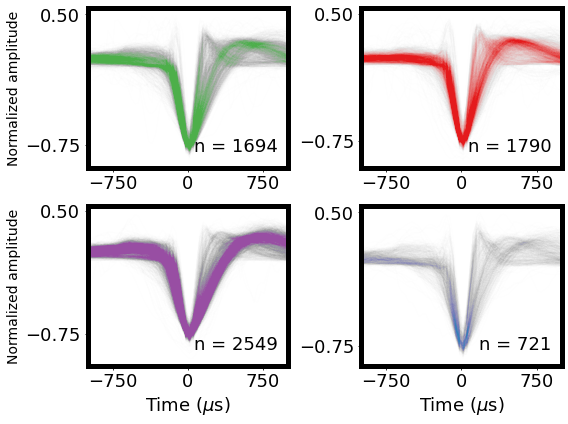

In [33]:
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(8, 6))
x = np.linspace(-1000, 1000, 1000)
for ni, n in enumerate(np.unique(unit_statistics_df.nuclei)):
    ax = axs.flatten()[ni]
    ax.set_rasterization_zorder(1)
    ax.plot(
        x,
        np.stack(
            unit_statistics_df[
                unit_statistics_df.nuclei == n
            ].best_chan_templates_norm.values
        )[::1].T,
        color=nuclei_dict[n],
        alpha=0.005,
        zorder=-10,
        rasterized=True
    )
    #ax.set_title(n, fontsize=14)
    if ni in [0,2]:
        ax.set_ylabel("Normalized amplitude", fontsize=14)
    if ni in [2,3]:
        ax.set_xlabel("Time ($\mu$s)", fontsize=18)
    [i.set_linewidth(5) for i in ax.spines.values()]
    ax.text(
        0.95,
        0.1,
        "n = {}".format(np.sum(unit_statistics_df.nuclei == n)),
        horizontalalignment="right",
        transform=ax.transAxes,
        fontsize=18,
    )
    ax.set_xticks([-750,0, 750])
    ax.set_yticks([-0.75, 0.5])
    ax.set_xlim([-1000, 1000])
    
    ax.xaxis.set_tick_params(labelsize=18)
    ax.yaxis.set_tick_params(labelsize=18)

plt.tight_layout()

ensure_dir(FIGURE_DIR / 'neural-results')
save_fig(FIGURE_DIR / 'neural-results' / 'region-spikes', save_pdf=True)
plt.show()

### UMAP and PCA PROJECTION

In [34]:
import hdbscan

In [35]:
from umap import UMAP

In [36]:
best_chan_templates_norm = np.stack(unit_statistics_df.best_chan_templates_norm.values)

In [37]:
umap_best_chan_templates_norm = UMAP(verbose=True, metric="euclidean").fit_transform(best_chan_templates_norm)

UMAP(verbose=True)
Construct fuzzy simplicial set
Sun Jan 23 18:04:16 2022 Finding Nearest Neighbors
Sun Jan 23 18:04:16 2022 Building RP forest with 9 trees
Sun Jan 23 18:04:17 2022 NN descent for 13 iterations
	 1  /  13
	 2  /  13
	 3  /  13
	Stopping threshold met -- exiting after 3 iterations
Sun Jan 23 18:04:35 2022 Finished Nearest Neighbor Search
Sun Jan 23 18:04:38 2022 Construct embedding
	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Sun Jan 23 18:04:49 2022 Finished embedding


In [38]:
from sklearn.decomposition import PCA 

In [39]:
pca_best_chan_templates_norm =  PCA().fit_transform(best_chan_templates_norm)

In [40]:
from cdcp.visualization.utils import get_scatter_limits

In [41]:
c = [ nuclei_dict[i] for i in unit_statistics_df.nuclei.values]

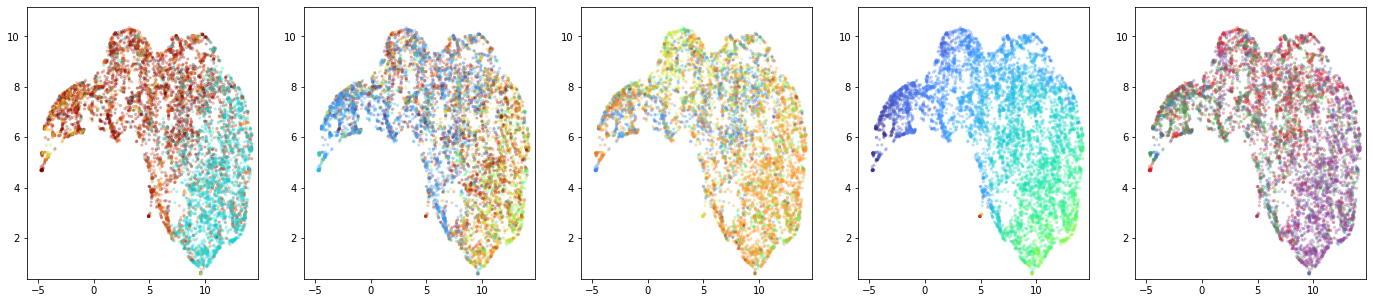

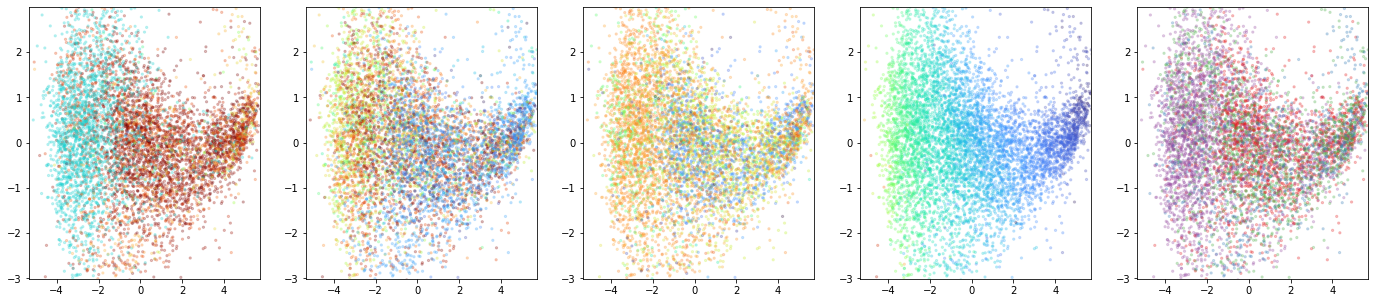

In [42]:
for z in [
    umap_best_chan_templates_norm,
    pca_best_chan_templates_norm,
]:
    xlim, ylim = get_scatter_limits(z[:, 0], z[:, 1], _range=90)
    s = 5
    alpha = 0.25
    fig, axs = plt.subplots(ncols=5, figsize=(24, 5))
    ax = axs[0]
    ax.scatter(z[:, 0], z[:, 1], c=unit_statistics_df.AP, s=s, alpha=alpha, cmap="turbo")
    ax = axs[1]
    ax.scatter(z[:, 0], z[:, 1], c=np.abs(unit_statistics_df.ML), s=s, alpha=alpha, cmap="turbo")
    ax = axs[2]
    ax.scatter(z[:, 0], z[:, 1], c=unit_statistics_df.DV, s=s, alpha=alpha, cmap="turbo")
    ax = axs[3]
    ax.scatter(z[:, 0], z[:, 1], c=unit_statistics_df.fw, s=s, alpha=alpha, cmap="turbo")

    ax = axs[4]
    ax.scatter(z[:, 0], z[:, 1], c=c, s=s, alpha=alpha)

    for ax in axs:
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
    plt.show()

# Cluster

In [44]:
def zero_one_norm(x):
    return (x-np.nanmin(x)) / (np.nanmax(x) - np.nanmin(x))

colors = plt.cm.turbo(zero_one_norm(unit_statistics_df.hw))

In [45]:
unit_statistics_df.hw.values

array([36, 61, 82, ..., 43, 61, 48])

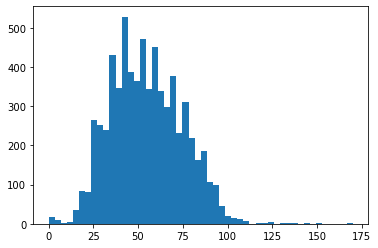

In [46]:
plt.hist(unit_statistics_df.hw.values, bins=50);

  0%|          | 0/676 [00:00<?, ?it/s]

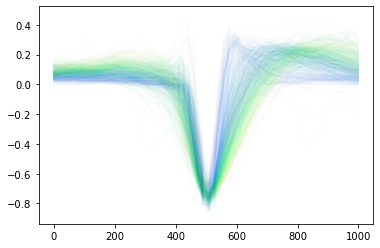

In [47]:
for i, ci in zip(best_chan_templates_norm[::10], tqdm(colors[::10])):
    plt.plot(i, c = ci, alpha = 0.01)

In [48]:
from sklearn import cluster

from sklearn.metrics import silhouette_samples, silhouette_score

from sklearn.metrics import davies_bouldin_score

from sklearn.mixture import GaussianMixture

In [49]:
ss_prev = 0
s_scores = []
db_scores = []
labs = []
comps = np.arange(2,10)
for n_clusters in tqdm(comps):
    clusterer = cluster.Birch(n_clusters=n_clusters)
    current_lab = clusterer.fit(best_chan_templates_norm).labels_
    ss = silhouette_score(best_chan_templates_norm, current_lab)
    db = davies_bouldin_score(best_chan_templates_norm, current_lab)
    s_scores.append(ss)
    labs.append(current_lab)
    db_scores.append(db)
    print(n_clusters, ss, db)

  0%|          | 0/8 [00:00<?, ?it/s]

2 0.4019483306056259 0.9410659150542692
3 0.26505985888979866 1.3404112946234328
4 0.23969818496254852 1.1934983426925436
5 0.22277491485521492 1.2263645080454104
6 0.22275961165732414 1.239660608669208
7 0.22627733260122482 1.2797421394386586
8 0.22595277825593335 1.1784230067859036
9 0.1957262638685603 1.2624702716820222


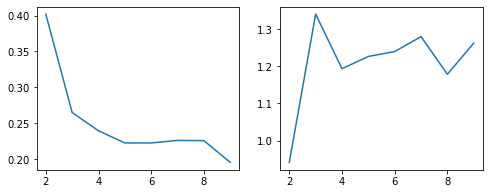

In [50]:
fig, axs = plt.subplots(figsize=(8,3), ncols=2)
axs[0].plot(comps, s_scores)
axs[1].plot(comps, db_scores)

In [51]:
lab = labs[1]
np.unique(lab, return_counts=True)

(array([0, 1, 2]), array([2710, 2131, 1913]))

In [52]:
real_clusters = np.unique(lab)

In [53]:
unit_statistics_df['unit_type'] = lab

#### Plot clusters 

In [54]:
from cdcp.visualization.utils import get_cat_colors

In [55]:
colors_lab, pal, pal_dict = get_cat_colors(lab, palette='Set2')

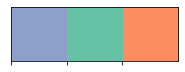

In [56]:
sns.palplot(pal)

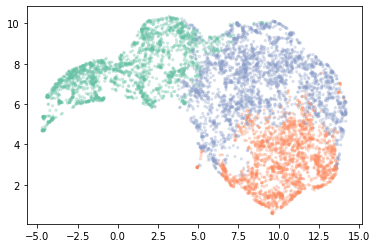

In [57]:
fig, ax  = plt.subplots()
z = umap_best_chan_templates_norm
c = colors_lab
ax.scatter(z[:, 0], z[:, 1], c=c, s=s, alpha=alpha)

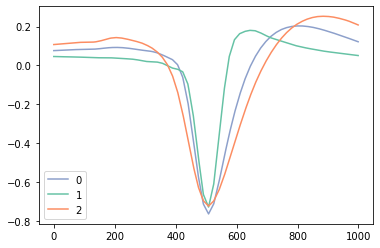

In [58]:
fig, ax = plt.subplots(figsize=(6,4))
for i, l in enumerate(np.unique(lab)):
    ax.plot(np.mean(best_chan_templates_norm[lab == l], axis=0), label=l, color = pal_dict[l])
ax.legend()

In [59]:
lab

array([1, 0, 0, ..., 1, 0, 0])

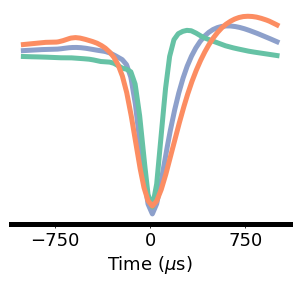

In [60]:
fig, ax = plt.subplots(figsize=(5, 4))
x = np.linspace(-1000, 1000, 1000)

for i, l in enumerate(np.unique(unit_statistics_df['unit_type'])):
    ax.plot(
        x,
        np.mean(best_chan_templates_norm[unit_statistics_df['unit_type'] == l], axis=0),
        label=l,
        color=pal_dict[l],
        lw=5,
    )
#ax.axis('off')
#ax.legend()
ax.axes.get_yaxis().set_visible(False)
ax.xaxis.set_tick_params(labelsize=18)

ax.spines["left"].set_linewidth(0)
ax.spines["right"].set_linewidth(0)
ax.spines["top"].set_linewidth(0)
ax.spines["bottom"].set_linewidth(5)
ax.set_xticks([-750, 0 , 750])
ax.set_xlabel("Time ($\mu$s)", fontsize=18)

ensure_dir(FIGURE_DIR / 'neural-results')
save_fig(FIGURE_DIR / 'neural-results' / 'spike-shapes', save_pdf=True)

plt.show()

In [61]:
ax.spines

OrderedDict([('left', <matplotlib.spines.Spine at 0x7f0b59236210>),
             ('right', <matplotlib.spines.Spine at 0x7f0b59236050>),
             ('bottom', <matplotlib.spines.Spine at 0x7f0b592360d0>),
             ('top', <matplotlib.spines.Spine at 0x7f0b59236690>)])

0it [00:00, ?it/s]

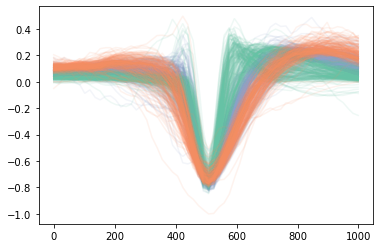

In [62]:
fig, ax = plt.subplots()
for li, nlabs in tqdm(enumerate(np.unique(lab))):
    ax.plot(best_chan_templates_norm[lab==nlabs][::10].T, alpha = 0.1, color = pal[li]);

In [63]:
spike_width_trough_to_peak = np.argmax(best_chan_templates_norm[:, 500:], axis=1)

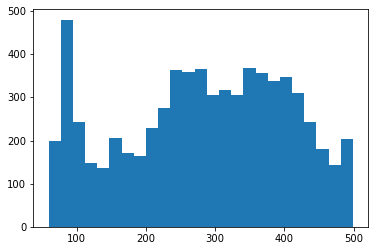

In [64]:
plt.hist(spike_width_trough_to_peak, bins=25);

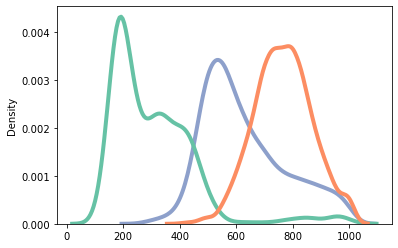

In [65]:
fig, ax = plt.subplots()
for i in real_clusters:
    sns.kdeplot(
        spike_width_trough_to_peak[unit_statistics_df["unit_type"] == i]*2,
        lw=4,
        color=pal_dict[i],
    )
    #ax.hist(
    #    spike_width_trough_to_peak[unit_statistics_df["unit_type"] == i]*2,
    #    #density=True,
    #    bins=np.linspace(0, 1000, 15),
    #    histtype=u"step",
    #    lw=4,
    #    alpha=0.75,
    #    color=pal_dict[i],
    #)

0it [00:00, ?it/s]

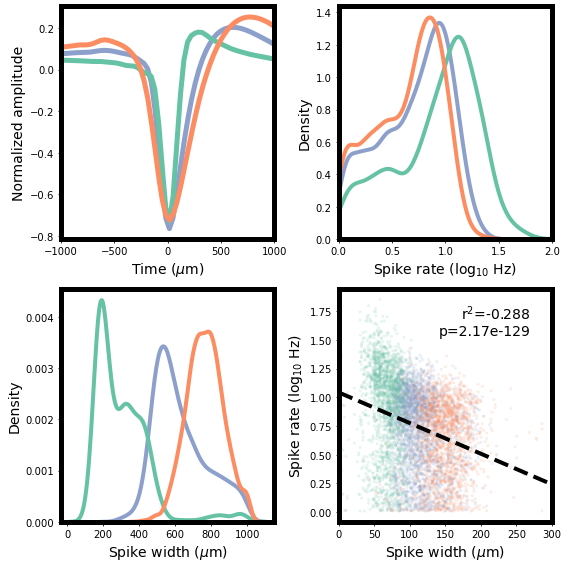

In [66]:
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(8, 8))
ax = axs.flatten()[0]
for li, nlabs in tqdm(enumerate(real_clusters)):
    ax.plot(
        np.linspace(-1000, 1000, 1000),
        np.mean(
            best_chan_templates_norm[nlabs == unit_statistics_df["unit_type"]], axis=0
        ),
        alpha=1,
        color=pal_dict[nlabs],
        lw=5,
    )
ax.set_xlim([-1000, 1000])

ax.set_xlabel("Time ($\mu$m)", fontsize=14)
ax.set_ylabel("Normalized amplitude", fontsize=14)

ax = axs.flatten()[1]
for i in real_clusters:
    if False:
        ax.hist(
            np.log(1 + unit_statistics_df.sr[unit_statistics_df["unit_type"] == i]),
            density=True,
            bins=np.linspace(0, 5, 40),
            histtype=u"step",
            lw=4,
            color=pal_dict[i],
            alpha=0.75,
        )
    else:
        sns.kdeplot(
            np.log10(1 + unit_statistics_df.sr[unit_statistics_df["unit_type"] == i]),
            lw=4,
            color=pal_dict[i],
            ax = ax,
            common_norm=True
        )
ax.set_xlim([0, 2])
ax.set_xlabel("Spike rate (log$_{10}$ Hz)", fontsize=14)
ax.set_ylabel("Density", fontsize=14)

ax = axs.flatten()[2]
for i in real_clusters:
    sns.kdeplot(
        spike_width_trough_to_peak[unit_statistics_df["unit_type"] == i]*2,
        lw=4,
        color=pal_dict[i],
        ax = ax,
        common_norm=True
    )
ax.set_xlabel("Spike width ($\mu$m)", fontsize=14)
ax.set_ylabel("Density", fontsize=14)
#ax.set_xlim([0, 300])

ax = axs.flatten()[3]
x = unit_statistics_df.hw.values*2
y = np.log10(1 + unit_statistics_df.sr.values)
ax.scatter(
    x,
    y,
    alpha=0.1,
    s=5,
    c=colors_lab,
)
mask = (np.isnan(x) == False) & (np.isnan(y) == False)
x = x[mask]
y = y[mask]
r2, p = scipy.stats.pearsonr(x, y)
m, b = np.polyfit(x, y, 1)
xmod = np.array([np.nanmin(x), np.nanmax(x)])
ymod = m * xmod + b
ax.plot(xmod, ymod, color="k", ls="dashed", lw=4)
# ax.set_yscale('log')
ax.set_xlim([0, 300])
ax.set_xlabel("Spike width ($\mu$m)", fontsize=14)
ax.set_ylabel("Spike rate (log$_{10}$ Hz)", fontsize=14)
ax.text(
    0.9,
    0.8,
    "r$^2$={:.3}\np={:.3}".format(r2, p),
    horizontalalignment="right",
    fontsize=14,
    transform=ax.transAxes,
)

for ax in axs.flatten():
    [i.set_linewidth(5) for i in ax.spines.values()]
plt.tight_layout()

ensure_dir(FIGURE_DIR / 'neural-results')
save_fig(FIGURE_DIR / 'neural-results' / 'unit-type-width-rate', save_pdf=True)
plt.show()

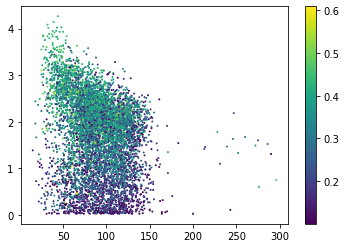

In [67]:
im = plt.scatter(unit_statistics_df.fw, np.log(1+unit_statistics_df.sr), alpha = 1, s=1, c = unit_statistics_df.categoricality)
plt.colorbar(im)

0it [00:00, ?it/s]

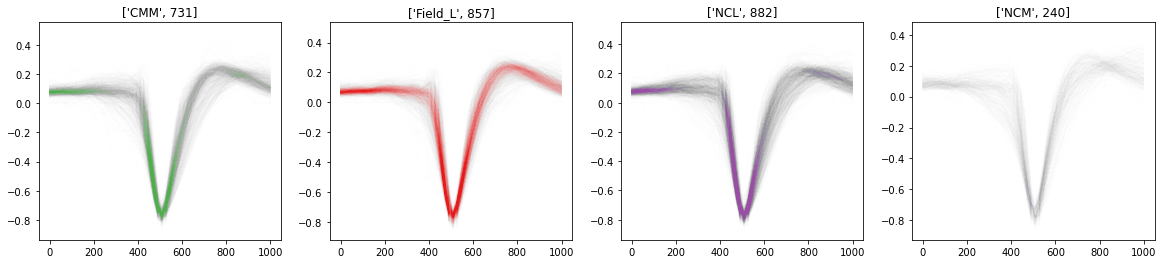

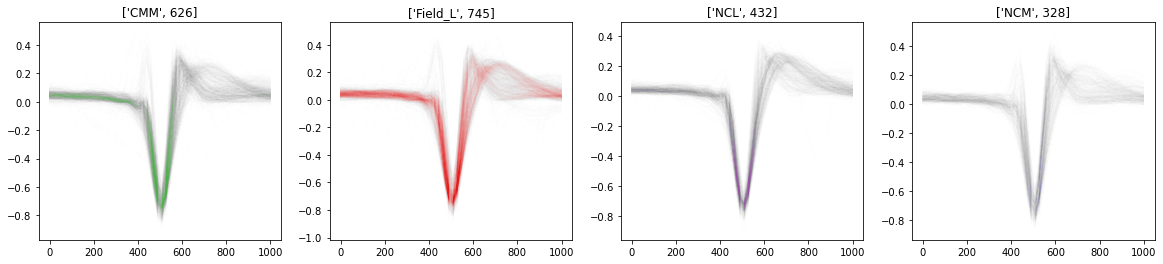

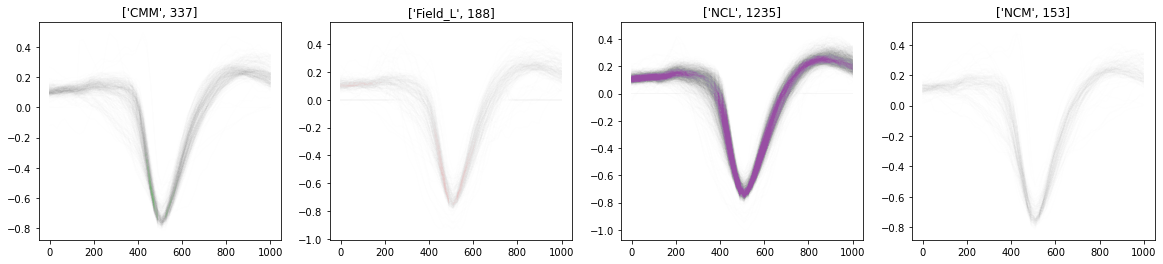

In [68]:
for li, nlabs in tqdm(enumerate(real_clusters)):
    fig, axs = plt.subplots(ncols=4, figsize=(20,4))
    for ni, n in enumerate(np.unique(unit_statistics_df.nuclei)):
        m = (unit_statistics_df.nuclei == n) & (lab == nlabs)
        if np.sum(m) == 0:
            continue
        ax = axs[ni]
        ax.plot(best_chan_templates_norm[m].T, color = nuclei_dict[n], alpha = 0.005)
        ax.set_title([n, np.sum(m)])
    plt.show()

### Relationship between unit type and nuclei

In [69]:
template_info[:3]

,best_chan_templates,best_chan_templates_norm,nuclei,AP,ML,DV,amplitude,template_amplitude,sr,fw,hw,bird,unit
2,"[22.0, 22.05905905905906, 22.11811811811812, 2...","[0.04386099708032402, 0.04397874204473111, 0.0...",NCL,2420.0,2717.25,-722.499502,-365.75,365.649900,18.982587,64.0,35,B1597,982
7,"[39.75, 39.528528528528525, 39.30705705705706,...","[0.05518305414255926, 0.05487559572240221, 0.0...",Field_L,2420.0,2544.25,-822.499502,-559.75,559.589339,10.697164,72.0,38,B1597,11599
8,"[27.0, 27.11811811811812, 27.236236236236238, ...","[0.03453874708847825, 0.03468984530359857, 0.0...",NCL,2420.0,2924.25,-762.499502,-587.00,586.815816,0.633780,60.0,36,B1597,6067


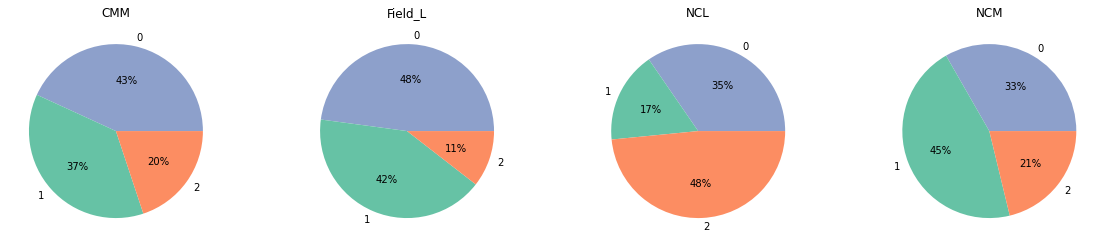

In [70]:
fig, axs = plt.subplots(ncols=4, figsize=(20,4))
for ni, n in enumerate(np.unique(unit_statistics_df.nuclei.values)):
    ax = axs[ni]
    ax.set_title(n)
    labels, sizes = np.unique(unit_statistics_df[unit_statistics_df.nuclei ==n].unit_type, return_counts = True)
    ax.pie(x=sizes, labels=labels, explode=None, colors = [pal_dict[i] for i in labels], autopct='%.0f%%');
plt.show()

In [71]:
pal_dict

{0: array([0.55294118, 0.62745098, 0.79607843]),
 1: array([0.4       , 0.76078431, 0.64705882]),
 2: array([0.98823529, 0.55294118, 0.38431373])}

In [72]:
import matplotlib

In [73]:
n

'NCM'

In [74]:
def autopct_format(values, labels, colors):
    def my_format(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return 'n={v:d}'.format(v=val)
    return my_format

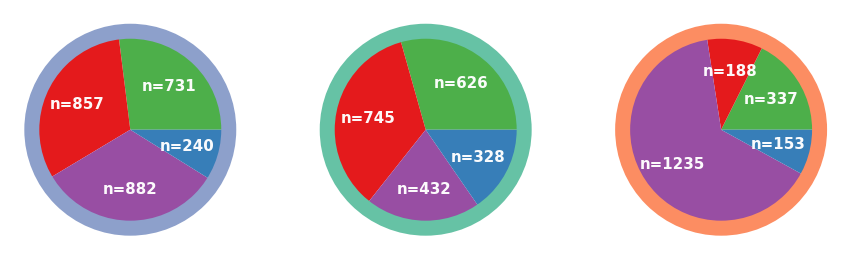

In [75]:
fig, axs = plt.subplots(
    ncols=len(np.unique(unit_statistics_df.unit_type.values)), figsize=(15, 5)
)
for ni, n in enumerate(np.unique(unit_statistics_df.unit_type.values)):
    ax = axs[ni]
    #ax.set_title(n)
    labels, sizes = np.unique(
        unit_statistics_df[unit_statistics_df.unit_type == n].nuclei, return_counts=True
    )
    slices, pie_labels, autopcts = ax.pie(
        x=sizes, labels=["" for i in sizes], explode=None, colors=[nuclei_dict[i] for i in labels],
        autopct = autopct_format(sizes, labels, [nuclei_dict[i] for i in labels])
        #wedgeprops={"edgecolor":pal_dict[n],'linewidth': 5, 'antialiased': True}

    )  # , autopct='%.0f%%');,
    for lab in autopcts:
        lab.set_fontsize(15)
        lab.set_fontweight("bold")
        lab.set_color("white")
        lab.set_alpha(0.975)
    center = slices[0].center
    r = slices[0].r
    # create a new circle with the desired properties
    circle = matplotlib.patches.Circle(center, r, fill=False, edgecolor=pal_dict[n], linewidth=15)
    # add the circle to the axes
    ax.add_patch(circle)

ensure_dir(FIGURE_DIR / 'neural-results')
save_fig(FIGURE_DIR / 'neural-results' / 'unit-type-nuclei', save_pdf=True)
plt.show()

### Save results

In [76]:
template_info[:3]

,best_chan_templates,best_chan_templates_norm,nuclei,AP,ML,DV,amplitude,template_amplitude,sr,fw,hw,bird,unit
2,"[22.0, 22.05905905905906, 22.11811811811812, 2...","[0.04386099708032402, 0.04397874204473111, 0.0...",NCL,2420.0,2717.25,-722.499502,-365.75,365.649900,18.982587,64.0,35,B1597,982
7,"[39.75, 39.528528528528525, 39.30705705705706,...","[0.05518305414255926, 0.05487559572240221, 0.0...",Field_L,2420.0,2544.25,-822.499502,-559.75,559.589339,10.697164,72.0,38,B1597,11599
8,"[27.0, 27.11811811811812, 27.236236236236238, ...","[0.03453874708847825, 0.03468984530359857, 0.0...",NCL,2420.0,2924.25,-762.499502,-587.00,586.815816,0.633780,60.0,36,B1597,6067


In [77]:
unit_statistics_df[['fw', 'sr', 'unit_type', 'best_chan_templates']][:3]

,fw,sr,unit_type,best_chan_templates
0,70.0,19.505140,1,"[29.0, 28.94094094094094, 28.88188188188188, 2..."
1,86.0,7.202434,0,"[29.5, 29.47047047047047, 29.44094094094094, 2..."
2,120.0,13.687375,0,"[42.75, 42.779529529529526, 42.80905905905906,..."


In [78]:
unit_statistics_df[
    [
        "fw",
        "sr",
        "unit_type",
        "unit",
        "bird",
        "best_chan_templates",
        "best_chan_templates_norm",
        "amplitude",
    ]
].to_pickle(DATA_DIR / "unit_classes_01_23_22.pickle")

In [79]:
unit_statistics_df[:3]

,bird,unit,categorical_unit,categoricality,best_chan_templates,best_chan_templates_norm,nuclei,AP,ML,DV,amplitude,template_amplitude,sr,fw,hw,unit_type
0,B1597,6270,True,0.420068,"[29.0, 28.94094094094094, 28.88188188188188, 2...","[0.04162189031853942, 0.04153712653652313, 0.0...",NCL,2420.0,2917.25,-722.499502,-515.25,520.843844,19.505140,70.0,36,1
1,B1597,935,True,0.265302,"[29.5, 29.47047047047047, 29.44094094094094, 2...","[0.07603293844777533, 0.07595682940028006, 0.0...",Field_L,2420.0,2344.25,-822.499502,-294.00,297.492993,7.202434,86.0,61,0
2,B1597,10839,True,0.296694,"[42.75, 42.779529529529526, 42.80905905905906,...","[0.1011863087601332, 0.10125620312487042, 0.10...",CMM,2420.0,1764.25,-742.499502,-314.00,317.487988,13.687375,120.0,82,0
